# Tutorial for Haystack usage

References:
* https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/mixtral-8x7b-for-web-qa.ipynb#scrollTo=pwp6S_iAC1DR

In [1]:
%pip install -q haystack-ai==2.1.1
%pip install -q huggingface-hub==0.23.0
%pip install -q transformers==4.40.2
%pip install -q accelerate==0.30.1
%pip install -q sentencepiece==0.2.0
%pip install -q datasets==2.19.1
%pip install -q sentence-transformers==2.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.0/319.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.3/320.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import yaml
from google.colab import drive
from getpass import getpass

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read YAML file
f_path = "/content/drive/MyDrive/GitHub/python-codebase/machine_learning/private_keys.yml"
with open(f_path, 'r') as stream:
    data_loaded = yaml.safe_load(stream)
os.environ['HF_API_TOKEN'] = data_loaded['HF_API_KEY']
os.environ['GITHUB_TOKEN'] = data_loaded['GITHUB_TOKEN']

## 1. Prompt the Model - Standalone

In [ ]:
from haystack.components.generators import HuggingFaceAPIGenerator

#model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_name = "HuggingFaceH4/zephyr-7b-beta"
#model_name = "google/gemma-7b"
#model_name = "google/flan-ul2"

generator = HuggingFaceAPIGenerator(
  api_type="serverless_inference_api",
  api_params={"model": model_name}
)

In [ ]:
result = generator.run("What's Natural Language Processing?", generation_kwargs={"max_new_tokens": 350})
print(result["replies"][0])



Natural Language Processing (NLP) is a subfield of Artificial Intelligence (AI) and Computer Science that deals with the interactions between computers and human (natural) languages. NLP is a complex field that involves a variety of techniques from linguistics, computer science, and artificial intelligence.

NLP is used to enable computers to understand, interpret, and generate human language. It is a critical component of many AI applications, including virtual assistants, chatbots, search engines, and language translation services.

NLP is essential for AI systems to understand and respond to human language in a more natural and intuitive way. It allows computers to process and analyze large volumes of text, identify patterns and relationships, and generate insights and recommendations based on that analysis.

NLP is also used to improve the accuracy and efficiency of language translation services, making it easier for people to communicate across language barriers.

In summary, NL

## 2. Use the model in a full RAG pipeline (on the web)

Note: Instead of the LinkContentFetcher, we can change this pipeline to use our own data source (such as a vector databse, documentation...)

In [ ]:
from haystack.components.fetchers.link_content import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.rankers import TransformersSimilarityRanker
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack import Pipeline

In [ ]:
fetcher = LinkContentFetcher()
converter = HTMLToDocument()
document_splitter = DocumentSplitter(split_by="word", split_length=50)
similarity_ranker = TransformersSimilarityRanker(top_k=3)

In [ ]:
prompt_template = """
According to these documents:

{% for doc in documents %}
  {{ doc.content }}
{% endfor %}

Answer the given question: {{question}}
Answer:
"""
prompt_builder = PromptBuilder(template=prompt_template)

In [ ]:
pipeline = Pipeline()
pipeline.add_component("fetcher", fetcher)
pipeline.add_component("converter", converter)
pipeline.add_component("splitter", document_splitter)
pipeline.add_component("ranker", similarity_ranker)
pipeline.add_component("prompt_builder", prompt_builder)
pipeline.add_component("llm", generator)

In [ ]:
pipeline.connect("fetcher.streams", "converter.sources")
pipeline.connect("converter.documents", "splitter.documents")
pipeline.connect("splitter.documents", "ranker.documents")
pipeline.connect("ranker.documents", "prompt_builder.documents")
pipeline.connect("prompt_builder.prompt", "llm.prompt")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - splitter: DocumentSplitter
  - ranker: TransformersSimilarityRanker
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceAPIGenerator
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [ ]:
question = "What do graphs have to do with Haystack?"
result = pipeline.run(
  {
    "prompt_builder": {"question": question},
    "ranker": {"query": question},
    "fetcher": {"urls": ["https://haystack.deepset.ai/blog/introducing-haystack-2-beta-and-advent"]},
    "llm":{"generation_kwargs": {"max_new_tokens": 350}}
  }
)
print(result['llm']['replies'][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

 In Haystack 1.x, graphs were used to implement pipelines as directed acyclic graphs (DAGs), while in Haystack 2.0, graphs are still used but they are now directed (multi)graphs that can branch out, join, and cycle back to another component, allowing for more complex pipelines with features such as retries and loops. This shift towards more explicit component functionality is aimed at making the framework more transparent and easier to use.


# 3. RAG pipeline

References:
* https://haystack.deepset.ai/tutorials/27_first_rag_pipeline

In [ ]:
from datasets import load_dataset
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.builders import PromptBuilder
from haystack.components.generators import HuggingFaceAPIGenerator

In [ ]:
if False:
  # Try document store
  document_store = InMemoryDocumentStore()
  document_store.write_documents([
    Document(content="My name is Jean and I live in Paris."),
    Document(content="My name is Mark and I live in Berlin."),
    Document(content="My name is Giorgio and I live in Rome.")
])

In [ ]:
# Load dataset
dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]
print(dataset[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/151 [00:00<?, ? examples/s]

{'id': 'b3de1a673c1eb2876585405395a10c3d', 'content': 'The Colossus of Rhodes (Ancient Greek: ὁ Κολοσσὸς Ῥόδιος, romanized:\xa0ho Kolossòs Rhódios Greek: Κολοσσός της Ρόδου, romanized:\xa0Kolossós tes Rhódou)[a] was a statue of the Greek sun-god Helios, erected in the city of Rhodes, on the Greek island of the same name, by Chares of Lindos in 280\xa0BC. One of the Seven Wonders of the Ancient World, it was constructed to celebrate the successful defence of Rhodes city against an attack by Demetrius Poliorcetes, who had besieged it for a year with a large army and navy.\nAccording to most contemporary descriptions, the Colossus stood approximately 70 cubits, or 33 metres (108 feet) high – approximately the height of the modern Statue of Liberty from feet to crown – making it the tallest statue in the ancient world.[2] It collapsed during the earthquake of 226 BC, although parts of it were preserved. In accordance with a certain oracle, the Rhodians did not build it again.[3] John Malal

In [ ]:
# Initalize a Document Embedder
'''
To store your data in the DocumentStore with embeddings, initialize a SentenceTransformersDocumentEmbedder with the model name and call warm_up() to download the embedding model.
'''
doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
doc_embedder.warm_up()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#document_store = InMemoryDocumentStore()
#document_store.write_documents(docs)

In [ ]:
# Write Documents to the DocumentStore
'''
The embedder will create embeddings for each document and save these embeddings in Document object’s embedding field.
Then, you can write the Documents to the DocumentStore with write_documents() method.
'''
document_store = InMemoryDocumentStore()
docs_with_embeddings = doc_embedder.run(docs)
document_store.write_documents(docs_with_embeddings["documents"])

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

151

## Building the RAG Pipeline

In [ ]:
# Initialize a Text Embedder
'''
Initialize a text embedder to create an embedding for the user query.
The created embedding will later be used by the Retriever to retrieve relevant documents from the DocumentStore.
'''
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
# Initialize the Retriever
'''
Initialize a InMemoryEmbeddingRetriever and make it use the InMemoryDocumentStore you initialized earlier in this tutorial.
This Retriever will get the relevant documents to the query.
'''
retriever = InMemoryEmbeddingRetriever(document_store)

In [ ]:
# Define a Template Prompt
'''
Create a custom prompt for a generative question answering task using the RAG approach.
The prompt should take in two parameters: documents, which are retrieved from a document store, and a question from the user.
Use the Jinja2 looping syntax to combine the content of the retrieved documents in the prompt.

Next, initialize a PromptBuilder instance with your prompt template.
The PromptBuilder, when given the necessary values, will automatically fill in the variable values and generate a complete prompt.
This approach allows for a more tailored and effective question-answering experience.
'''

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

In [ ]:
# Initialize a Generator
'''
Generators are the components that interact with large language models (LLMs).
'''
#model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_name = "HuggingFaceH4/zephyr-7b-beta"
#model_name = "google/gemma-7b"
#model_name = "google/flan-ul2"

generator = HuggingFaceAPIGenerator(
  api_type="serverless_inference_api",
  api_params={"model": model_name}
)

In [ ]:
# Try LLM
result = generator.run("What's Natural Language Processing?", generation_kwargs={"max_new_tokens": 350})
print(result["replies"][0])



Natural Language Processing (NLP) is a subfield of Artificial Intelligence (AI) and Computer Science that deals with the interactions between computers and human (natural) languages. NLP is a complex field that involves a variety of techniques from linguistics, computer science, and artificial intelligence.

NLP is used to enable computers to understand, interpret, and generate human language. It is a critical component of many AI applications, including virtual assistants, chatbots, search engines, and language translation services.

NLP is essential for AI systems to understand and respond to human language in a more natural and intuitive way. It allows computers to process and analyze large volumes of text, identify patterns and relationships, and generate insights and recommendations based on that analysis.

NLP is also used to improve the accuracy and efficiency of language translation services, making it easier for people to communicate across language barriers.

In summary, NL

In [ ]:
# Build the Pipeline
'''
To build a pipeline, add all components to your pipeline and connect them.
Create connections from text_embedder’s “embedding” output to “query_embedding” input of retriever, from retriever to prompt_builder and from prompt_builder to llm.
Explicitly connect the output of retriever with “documents” input of the prompt_builder to make the connection obvious as prompt_builder has two inputs (“documents” and “question”).
'''
# Set up pipeline
basic_rag_pipeline = Pipeline()

# Add components to your pipeline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Now, connect the components to each other
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceAPIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [ ]:
question = "What does Rhodes Statue look like?"
response = basic_rag_pipeline.run(
    {
      "text_embedder":  {"text": question},
      "prompt_builder": {"question": question}
    }
)
print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 While scholars do not know what the statue looked like, they do have a good idea of what the head and face looked like, as it was of a standard rendering at the time. The head would have had curly hair with evenly spaced spikes of bronze or silver flame radiating, similar to the images found on contemporary Rhodian coins.


In [ ]:
# Visualize pipelines
basic_rag_pipeline.draw("rag_pipeline.png")

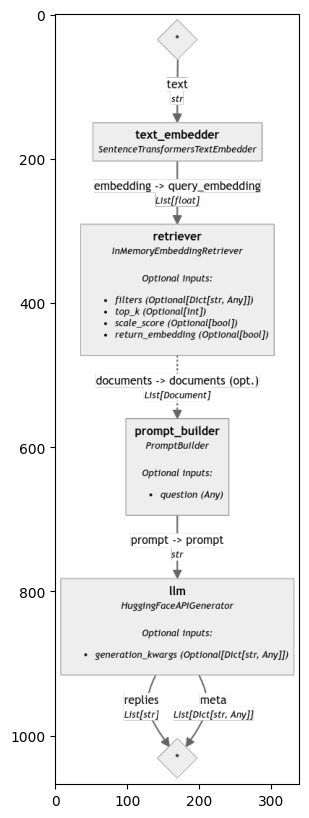

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('rag_pipeline.png')
plt.figure(figsize = (100,10))
plt.imshow(img)
plt.show()

![](/content/rag_pipeline.png)

# 4. Generating Structured Output with Loop-Based Auto-Correction

References:
* https://haystack.deepset.ai/tutorials/28_structured_output_with_loop
* Remove Tememetry (sharing statistics w/ Haystack): https://docs.haystack.deepset.ai/docs/telemetry
* https://pypi.org/project/pydantic/
* https://docs.haystack.deepset.ai/docs/generators!

In [30]:
import os
import logging
import json
import random
import pydantic
from pydantic import ValidationError
from pydantic import BaseModel
from typing import Optional, List
from haystack import component
from haystack.components.builders import PromptBuilder
from haystack.components.generators import HuggingFaceAPIGenerator
from haystack import Pipeline

In [10]:
os.environ["HAYSTACK_TELEMETRY_ENABLED"] = 'False'

In [11]:
logging.basicConfig()
logging.getLogger("canals.pipeline.pipeline").setLevel(logging.DEBUG)

In [22]:
# Pydantic example
if False:
  from datetime import datetime
  from typing import List, Optional
  from pydantic import BaseModel

  class User(BaseModel):
      id: int
      name: str = 'John Doe'
      signup_ts: Optional[datetime] = None
      friends: List[int] = []

  external_data = {'id': '123', 'signup_ts': '2017-06-01 12:22', 'friends': [1, '2', b'3']}
  user = User(**external_data)
  print(user)
  #> User id=123 name='John Doe' signup_ts=datetime.datetime(2017, 6, 1, 12, 22) friends=[1, 2, 3]
  print(user.id)
  #> 123
  # Error, since data type for 'friends' is incorrect
  User(**{'id': '123', 'signup_ts': '2017-06-01 12:22', 'friends': ['A']})
  #>ValidationError: 1 validation error for User friends. Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='A', input_type=str]

In [5]:
# Defining a Schema to Parse the JSON Object
'''
Define a simple JSON schema for the data you want to extract from a text passsage using the LLM.
As the first step, define two Pydantic models, City and CitiesData, with suitable fields and types.
'''
class City(BaseModel):
    name: str
    country: str
    population: int

class CitiesData(BaseModel):
    cities: List[City]

# Generate a JSON schema from Pydantic models using schema_json()
json_schema = CitiesData.schema_json(indent=2)

In [41]:
print(json_schema)

{
  "$defs": {
    "City": {
      "properties": {
        "name": {
          "title": "Name",
          "type": "string"
        },
        "country": {
          "title": "Country",
          "type": "string"
        },
        "population": {
          "title": "Population",
          "type": "integer"
        }
      },
      "required": [
        "name",
        "country",
        "population"
      ],
      "title": "City",
      "type": "object"
    }
  },
  "properties": {
    "cities": {
      "items": {
        "$ref": "#/$defs/City"
      },
      "title": "Cities",
      "type": "array"
    }
  },
  "required": [
    "cities"
  ],
  "title": "CitiesData",
  "type": "object"
}


In [8]:
# Creating a Custom Component: OutputValidator
'''
OutputValidator is a custom component that validates if the JSON object the LLM generates complies with the provided Pydantic model.
If it doesn’t, OutputValidator returns an error message along with the incorrect JSON object to get it fixed in the next loop.
'''
# Define the component input parameters
@component
class OutputValidator:
    """

    Attributes:
      pydantic_model:
      iteration_counter:
    """
    def __init__(self, pydantic_model: pydantic.BaseModel):
        self.pydantic_model = pydantic_model
        self.iteration_counter = 0

    # Define the component output
    @component.output_types(valid_replies=List[str], invalid_replies=Optional[List[str]], error_message=Optional[str])
    def run(self, replies: List[str]):

        self.iteration_counter += 1

        ## Try to parse the LLM's reply ##
        # If the LLM's reply is a valid object, return `"valid_replies"`
        try:
            output_dict = json.loads(replies[0])
            self.pydantic_model.parse_obj(output_dict)
            print(
                f"OutputValidator at Iteration {self.iteration_counter}: Valid JSON from LLM - No need for looping: {replies[0]}"
            )
            return {"valid_replies": replies}

        # If the LLM's reply is corrupted or not valid, return "invalid_replies" and the "error_message" for LLM to try again
        except (ValueError, ValidationError) as e:
            print(
                f"OutputValidator at Iteration {self.iteration_counter}: Invalid JSON from LLM - Let's try again.\n"
                f"Output from LLM:\n {replies[0]} \n"
                f"Error from OutputValidator: {e}"
            )
            return {"invalid_replies": replies, "error_message": str(e)}


In [47]:
# Create an OutputValidator instance with CitiesData that you have created before.
output_validator = OutputValidator(pydantic_model=CitiesData)

In [69]:
# Creating the Prompt
'''
Write instructions for the LLM for converting a passage into a JSON format.
Ensure the instructions explain how to identify and correct errors if the JSON doesn’t match the required schema.
Once you create the prompt, initialize PromptBuilder to use it.
'''

prompt_template = """
Create a JSON object from the information present in this passage: {{passage}}.
Only use information that is present in the passage. Follow this JSON schema, but only return the actual instances without any additional schema definition:
{{schema}}
Make sure your response is a dict and not a list.
{% if invalid_replies and error_message %}
  You already created the following output in a previous attempt: {{invalid_replies}}
  However, this doesn't comply with the format requirements from above and triggered this Python exception: {{error_message}}
  Correct the output and try again. Just return the corrected output without any extra explanations.
{% endif %}
"""
prompt_builder = PromptBuilder(template=prompt_template)

In [46]:
# Initalizing the Generator
'''
Generators are the components that interact with large language models (LLMs).
'''
#model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_name = "HuggingFaceH4/zephyr-7b-beta"
#model_name = "google/gemma-7b"
#model_name = "google/flan-ul2"

generator = HuggingFaceAPIGenerator(
  api_type="serverless_inference_api",
  api_params={"model": model_name}
)

In [48]:
# Building the Pipeline
'''
Add all components to your pipeline and connect them.
Add connections from output_validator back to the prompt_builder for cases where the produced JSON doesn’t comply with the JSON schema.
Set max_loops_allowed to avoid infinite looping
'''

pipeline = Pipeline(max_loops_allowed=10)

# Add components to your pipeline
pipeline.add_component(instance=prompt_builder, name="prompt_builder")
pipeline.add_component(instance=generator, name="llm")
pipeline.add_component(instance=output_validator, name="output_validator")

# Now, connect the components to each other
pipeline.connect("prompt_builder", "llm")
pipeline.connect("llm", "output_validator")
# If a component has more than one output or input, explicitly specify the connections:
pipeline.connect("output_validator.invalid_replies", "prompt_builder.invalid_replies")
pipeline.connect("output_validator.error_message", "prompt_builder.error_message")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceAPIGenerator
  - output_validator: OutputValidator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> output_validator.replies (List[str])
  - output_validator.invalid_replies -> prompt_builder.invalid_replies (Optional[List[str]])
  - output_validator.error_message -> prompt_builder.error_message (Optional[str])

In [49]:
# Visualize pipeline
pipeline.draw("auto-correct-pipeline.png")

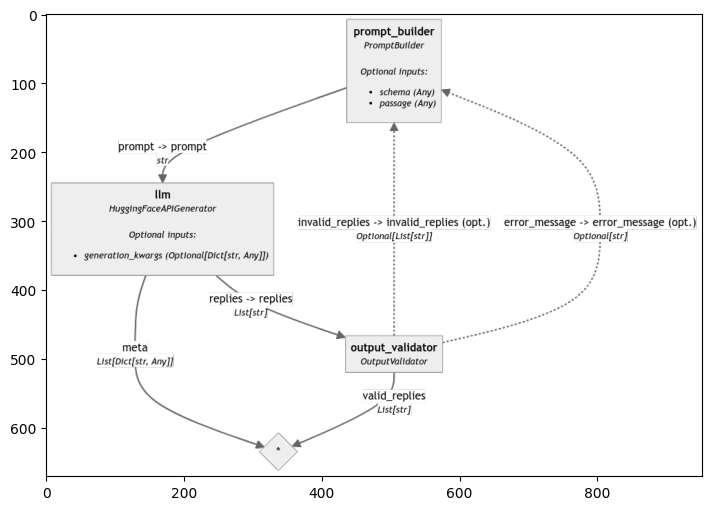

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('auto-correct-pipeline.png')
plt.figure(figsize = (40,6))
plt.imshow(img)
plt.show()

In [70]:
# Testing the Pipeline
'''
Run the pipeline with an example passage that you want to convert into a JSON format
and the json_schema you have created for CitiesData
'''
passage = "Berlin is the capital of Germany. It has a population of 3,850,809. Paris, France's capital, has 2.161 million residents. Lisbon is the capital and the largest city of Portugal with the population of 504,718."
result = pipeline.run({"prompt_builder": {"passage": passage, "schema": json_schema}})

OutputValidator at Iteration 23: Invalid JSON from LLM - Let's try again.
Output from LLM:
 Generate according to: Create a JSON object from the information present in this passage: The 2018 FIFA World Cup was the 21st FIFA World Cup, an international men's football tournament contested by 32 national teams and taking place in Russia from 14 June to 15 July 2018. It was the first World Cup to be held in Eastern Europe, and the 11th time that it had been held in Europe. At an estimated cost of over $14.2 billion, it is the most expensive World Cup. France won the tournament for the second time, beating Croatia 4–2 in the final, while England finished third.
Only use information that is present in the passage. Follow this JSON schema, but only return the actual instances without any additional schema definition:
{
  "$defs": {
    "Match": {
      "properties": {
        "winner": {
          "title": "Winner",
          "type": "string"
        },
        "score": {
          "title": "

PipelineMaxLoops: Maximum loops count (10) exceeded for component 'prompt_builder'

In [ ]:
# Print the Correct JSON
valid_reply = result["output_validator"]["valid_replies"][0]
valid_json = json.loads(valid_reply)
print(valid_json)

In [102]:
# Example (w/o pipelines)
#model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta"
#model_name = "google/gemma-7b"
#model_name = "google/flan-ul2"

generator1 = HuggingFaceAPIGenerator(
  api_type="serverless_inference_api",
  api_params={"model": model_name}
)
input_prompt = (
    prompt_template
    .replace('{{passage}}', passage)
    .replace('{{schema}}', json_schema)
    .split('{% if invalid_replies and error_message %}')[0]
)
result = generator1.run(input_prompt, generation_kwargs={"max_new_tokens": 250})
print(result["replies"][0])

HfHubHTTPError: 429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/HuggingFaceH4/zephyr-7b-beta (Request ID: WwT70iNr7bBoV07h3TWou)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate

In [88]:
print(input_prompt)


Create a JSON object from the information present in this passage: Berlin is the capital of Germany. It has a population of 3,850,809. Paris, France's capital, has 2.161 million residents. Lisbon is the capital and the largest city of Portugal with the population of 504,718..
Only use information that is present in the passage. Follow this JSON schema, but only return the actual instances without any additional schema definition:
{
  "$defs": {
    "City": {
      "properties": {
        "name": {
          "title": "Name",
          "type": "string"
        },
        "country": {
          "title": "Country",
          "type": "string"
        },
        "population": {
          "title": "Population",
          "type": "integer"
        }
      },
      "required": [
        "name",
        "country",
        "population"
      ],
      "title": "City",
      "type": "object"
    }
  },
  "properties": {
    "cities": {
      "items": {
        "$ref": "#/$defs/City"
      },
     

In [71]:
# Example (w/o validator)
#result = generator.run(passage, generation_kwargs={"max_new_tokens": 1000})
#print(result["replies"][0])

# Instantiate components
prompt_builder = PromptBuilder(template=prompt_template)
generator = HuggingFaceAPIGenerator(
  api_type="serverless_inference_api",
  api_params={"model": model_name}
)

# Add components to your pipeline
pipeline1 = Pipeline(max_loops_allowed=10)
pipeline1.add_component(instance=prompt_builder, name="prompt_builder")
pipeline1.add_component(instance=generator, name="llm")

# Now, connect the components to each other
pipeline1.connect("prompt_builder", "llm")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceAPIGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)

In [72]:
print(passage)

Berlin is the capital of Germany. It has a population of 3,850,809. Paris, France's capital, has 2.161 million residents. Lisbon is the capital and the largest city of Portugal with the population of 504,718.


In [75]:
print(json_schema)

{
  "$defs": {
    "City": {
      "properties": {
        "name": {
          "title": "Name",
          "type": "string"
        },
        "country": {
          "title": "Country",
          "type": "string"
        },
        "population": {
          "title": "Population",
          "type": "integer"
        }
      },
      "required": [
        "name",
        "country",
        "population"
      ],
      "title": "City",
      "type": "object"
    }
  },
  "properties": {
    "cities": {
      "items": {
        "$ref": "#/$defs/City"
      },
      "title": "Cities",
      "type": "array"
    }
  },
  "required": [
    "cities"
  ],
  "title": "CitiesData",
  "type": "object"
}


In [76]:
result = pipeline1.run({"prompt_builder": {"passage": 'City - Madrid - Population - 10M', "schema": json_schema}})
result

{'llm': {'replies': ['Generate according to: This is a list of cities with their populations.\nCity,Country,Population\nMadrid,Spain,1000000\nDelhi,India,2500000\nBeijing,China,2100000\nShanghai,China,2400000\nDhaka,Bangladesh,2000000\nMumbai,India,2200000\nOsaka,Japan,1900000\nCairo,Egypt,2000000\nSao Paulo,Brazil,2200000\nJakarta,Indonesia,1070000\nBangkok,Thailand,1200000\nSeoul,South Korea,1050000\nMexico City,Mexico,2100000\nGuangzhou,China,1400000\nTehran,Iran,1210000\nManila,Philippines,2100000\nTianjin,China,1600000\nLagos,Nigeria,2100000\nRio de Janeiro,Brazil,640000\nKarachi,Pakistan,2500000\nKolkata,India,1800000\nHo Chi Minh City,Vietnam,900000\nChennai,India,740000\nDhaka,Bangladesh,2000000\nLahore,Pakistan,1100000\nKharkiv,Ukraine,1700000\nOsaka,Japan,1900000\nKarachi,Pakistan,2500000\nKolkata,India,1800000\nHo Chi Minh City,Vietnam,900000\nChennai,India,740000\nDhaka,Bang'],
  'meta': [{'model': 'HuggingFaceH4/zephyr-7b-beta',
    'finish_reason': None,
    'usage': {'co

In [67]:
result['llm']['replies'][0]

'Generate according to: Create a JSON object from the information present in this passage: The 2018 FIFA World Cup was the 21st FIFA World Cup, an international men\'s football tournament contested by 32 national teams and taking place in Russia from 14 June to 15 July 2018. It was the first World Cup to be held in Eastern Europe, and the 11th time that it had been held in Europe. At an estimated cost of over $14.2 billion, it is the most expensive World Cup. France won the tournament for the second time, beating Croatia 4–2 in the final, while England finished third.\nOnly use information that is present in the passage. Follow this JSON schema, but only return the actual instances without any additional schema definition:\n{\n  "$defs": {\n    "Match": {\n      "properties": {\n        "winner": {\n          "title": "Winner",\n          "type": "string"\n        },\n        "score": {\n          "title": "Score",\n          "type": "string"\n        }\n      },\n      "required": [\n

# 5. Evaluating RAG Pipelines

References:
* https://haystack.deepset.ai/tutorials/35_evaluating_rag_pipelines

# 6. Agent builder

Pipelines are encapsuled within functions, so calling those functions executes all the pipeline associated to an LLM.

References:
* https://haystack.deepset.ai/tutorials/40_building_chat_application_with_function_calling